<a href="https://colab.research.google.com/github/maximilianoPizarro/Machine-Learning/blob/master/face_recognizer_support_vector_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROYECTO:  Reconocimiento facial usando eigenfaces y SVM


**Descripción del proyecto:** En este proyecto vamos a usar el dataset de  rostros de sklearn "Label Faces in the Wild"
[Dataset implementado](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (233MB) 

[Funte Sklearn](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)




**Indice:**


0.   [Preparando el entorno](#section0)
1.  [Entendimiento del negocio](#section1)
2.  [Entendimiento de los datos](#section2)
3.  [Modelado](#section3)
4.  [Preparación de los datos](#section4)
5.  [Implementación](#section5)
6.  [Evaluación](#section6)
7.  [Presentación](#section7)




###0) Preparando el entorno



Pasos de control

**0.**   Controlar que el entorno este configurado con python 3 (menu -> Entorno de ejecución -> Cambiar tipo de entorno de Ejecución)<br/>
**1.**   Instalar las librerias necesarias (haciendo uso de ! y apt-get o pip)<br/>
**2.**   Importar modulos <br/>
**3.**   Cargar al servidor la base de datos<br/>

In [0]:
#1 Instalar librerias

In [0]:
#2 importar librerias
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt
import pandas as pd #libreria para trabajar matrices de datos
import numpy as np


from sklearn.datasets import fetch_lfw_people



In [2]:
#3 Descargar la bd
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

###1) Entendimiento del Negocio

In [0]:
n_samples, h, w = lfw_people.images.shape #sirve la divicion para hacer el plotting

Se filtraran del dataset 70 rostros y se realizara 
su prediccion utilizando los algoritmos e eigenfaces y sopport-vector-machine

In [9]:
print(lfw_people.DESCR) #descripcion del dataset

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

###2) Entendimiento de los Datos



In [11]:
lfw_people #descripcion de los datos

{'DESCR': ".. _labeled_faces_in_the_wild_dataset:\n\nThe Labeled Faces in the Wild face recognition dataset\n------------------------------------------------------\n\nThis dataset is a collection of JPEG pictures of famous people collected\nover the internet, all details are available on the official website:\n\n    http://vis-www.cs.umass.edu/lfw/\n\nEach picture is centered on a single face. The typical task is called\nFace Verification: given a pair of two pictures, a binary classifier\nmust predict whether the two images are from the same person.\n\nAn alternative task, Face Recognition or Face Identification is:\ngiven the picture of the face of an unknown person, identify the name\nof the person by referring to a gallery of previously seen pictures of\nidentified persons.\n\nBoth Face Verification and Face Recognition are tasks that are typically\nperformed on the output of a model trained to perform Face Detection. The\nmost popular model for Face Detection is called Viola-Jones

In [12]:
#A quien pertenecen los rostros del dataset 
for name in lfw_people.target_names:
        print(name)

Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Tony Blair


In [0]:
#Dividimos el dataset segun la variable target
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


**Recordamos que la distirbución de la variable target no tenia una distribución normal**

In [16]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [0]:
 df=pd.DataFrame(y)

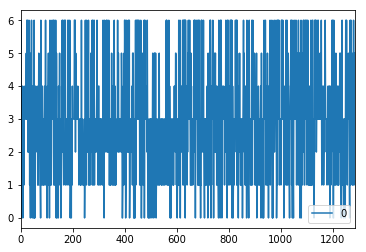

In [32]:
df.plot()

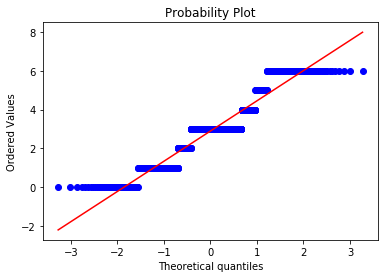

In [33]:
from scipy import stats #visualizar la distribución de probabilidades
#sirve para comprender si la variable en estudio tiene una distirbución normal
#necesaria para aplicar modelos paramétricos
stats.probplot(y, plot=plt)
plt.show()


Veremos en la etapa de preparación de los datos como corregir este problema.


### 3) Modelado


Usaremos modelo de clasificacion  SVM de sklearn



---

***Nota:**  Veamos que nos ofrece la libreria a utilizar para clasificacion (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

###4) Preparación de los datos

En esta etapa preparaemos el dataset



4.1) Split Dataset

In [0]:
from sklearn.model_selection import train_test_split

debemos definir 2 elementos:
1.   El porcentaje de registros que utilizaremos para testear
2.   Un valor aleatorio fijo para mantener la reproducción del experimento



In [0]:
test_size = 0.25 # 30% de la población (usualmente se elige entre un 30 y un 15% según la cantidad de registros)
RANDOM_STATE = 42 #un valor aleatorio

In [0]:
#por motivos de comparación tendremos separadas en 2 bds sin modificar
#raw
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)



In [36]:
print("train: {} vs test {}".format(len(X_train), len(X_test)))

train: 966 vs test 322


###5) Implementación

5.1) Modelo *Eigenfaces*

In [0]:
from sklearn.decomposition import PCA

In [38]:
# #############################################################################
# Entrenando con PCA
# extraccion no supervisada mediante PCA(sin tener en cuenta los labels del dataset)
n_components = 150

print("Extrayendo la parte superior %d eigenfaces de %d rostros"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X_train)
print("Terminado en %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Proyectando los datos de entrada de eigenfaces en conjunto de vectores basico(ortonormal)")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Terminado en in %0.3fs" % (time() - t0))

Extrayendo la parte superior 150 eigenfaces de 966 rostros
Terminado en 0.388s
Proyectando los datos den entrada de eigenfaces en conjunto de vectores basico(ortonormal)
terminado en in 0.052s


5.2) Modelo *SVM*

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [39]:
# #############################################################################
# Entrenando con SVM 
# Uso modelo de seleccion Grid Search CV

print("Ajuste de clasificacodor para el conjunto de entrenamiento")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)

clf = clf.fit(X_train_pca, y_train)
print("Terminado en %0.3fs" % (time() - t0))
print("Mejor estimacion por Grid Search:")
print(clf.best_estimator_)


Ajuste de clasificacodor para el conjunto de entrenamiento
Terminado en 47.202s
Mejor estimacion por Grid Search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


##6) Evaluación

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

6.1) Evaluación cuantitativa de la calidad del modelo en el conjunto de pruebas.



In [41]:
print("Prediciendo los nombres de las personas del conjunto de pruebas")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("Terminado en %0.3fs" % (time() - t0))

Prediciendo los nombres de las personas del conjunto de pruebas
Terminado en 0.085s


In [42]:
#Reporte utilizando el clasificador de reportes de sklearn
print(classification_report(y_test, y_pred, target_names=target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.85       322
        macro avg       0.89      0.72      0.78       322
     weighted avg       0.86      0.85      0.84       322



In [44]:
#matris de confucion
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  6   1   0   6   0   0   0]
 [  2  52   0   6   0   0   0]
 [  0   3  17   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   2   1   8   0]
 [  0   2   1   6   0   0  27]]


6.2) Evaluación cuantitativa de la prediccion usando matplotlib

In [0]:
# #############################################################################
# Evaluación cuantitativa de la prediccion usando matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


In [0]:
# plot una porcion del resultado del entrenamiento

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'prediccion: %s\ntrue:      %s' % (pred_name, true_name)

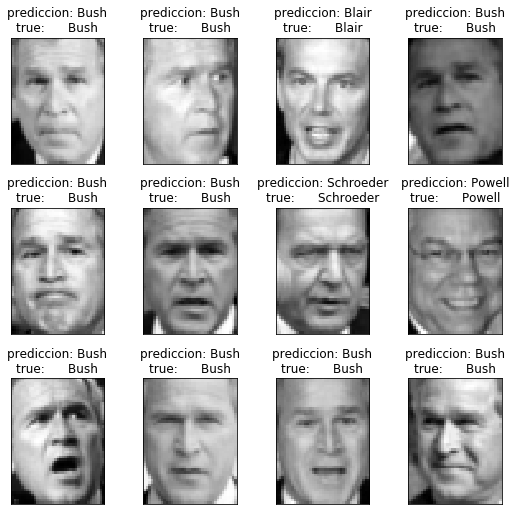

In [49]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

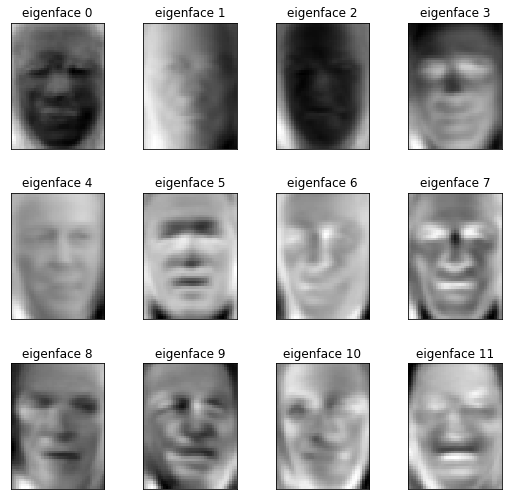

In [50]:
# plot los más significantes de la galeria de eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

##7) Impacto de variables